In [1]:
# add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

# #sklearnex
# from sklearnex import patch_sklearn
# patch_sklearn()
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
# StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import (accuracy_score,
                            recall_score,
                            precision_score,
                            f1_score,
                            roc_auc_score,
                            roc_curve,
                            matthews_corrcoef,
)
import cv2 as cv
from radiomics import featureextractor
from tqdm import tqdm
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler

#Import paths and patients classes
from notebooks.info import path_label, patient
import notebooks.utils as utils

# Feature extraction

In [2]:
def extractor_settings(param_path, show=False):
    """set extraction settings for pyradiomics

    Args:
        param_path (str): relative path of parameter file
        show (bool, optional): if printing setting or not. Defaults to False.

    Returns:
        obj: extractor of pyradiomics
    """
    extractor = featureextractor.RadiomicsFeatureExtractor(str(repo_path /param_path))
    if show:
        print('Extraction parameters:\n\t', extractor.settings)
        print('Enabled filters:\n\t', extractor.enabledImagetypes)
        print('Enabled features:\n\t', extractor.enabledFeatures)
    return extractor

def feature_extraction(df: pd.DataFrame, pat: object, rad: str, time: int, stype: str, i: int):
    """extract features based on the patient, radiologiest, time and segmentation type.
    Return a dataframe with the features

    Args:
        df (pd.DataFrame): df for the accumulation of the features of ALL PATIENTS
        pat (object): patient object
        rad (str): radiologist
        time (int): time 1 or 2
        stype (str): general or focal
        i (int): location in df

    Returns:
        _type_: _description_
    """
    im = sitk.JoinSeries(pat.im_sitk('SET')) #Add dimension to be able to use pyradiomics. Image (a,b) turns into (a,b,1)
    #get radiomics features
    param_path = 'data/param_files/Param_64bin_all_radiomics.json' #path of parameter file
    extractor = extractor_settings(param_path, show=False)
    #mask path
    mask_path = str(repo_path / pat.seg_path(rad, time, stype)[0])
    #extract
    result = extractor.execute(im,mask_path) # Extract features
    #feature vector length
    fv_len = 102
    print(list(result.values())[-fv_len:])
    #create df is not yet defined
    if df is None:
        column_names = list(result.keys())[-fv_len:] #get column names
        column_names = [x.replace('original_','') for x in column_names] #remove original_ string
        column_names.insert(0, 'pat_num') #insert pat_num at the beginning
        df = pd.DataFrame(columns=column_names)
    #add feature vector to df if it has values
    feature_vector = list(result.values())[-fv_len:] #get feature vector
    feature_vector.insert(0, pat.pat_num) #insert pat_num at the beginning
    #add feature vector according to loc
    df.loc[i] = feature_vector
    return df

Features for all patients are extracted for one configuration (time, radiologist and seg type) and concatenated to one dataframe, the general dataframe.
We generate two types of csv files:
- Individual configuration features file
- General (all configurations) features file

In [3]:
# initialize information class
info = path_label()
# select segmentation type
stype='G'

general_df = None # all radiologists and times in one df
for rad in ['L', 'V', 'M']:
    for time in [1,2]:
        df = None # df to store fv of one configuration
        for i in tqdm(range(info.len)): # go thourgh all patients
            pat = patient(info, num=i)
            df = feature_extraction(df, pat, rad, time, stype, i)
            clear_output(wait=True)
        general_df = pd.concat([general_df, df], ignore_index=True) # concatenate all times and radiologist results in one single df
        df.to_csv(repo_path / 'data' / 'features' / f'features_{rad}_{time}_{stype}.csv') # store one configuration
general_df.to_csv(repo_path / 'data' / 'features' / f'features_all_time{stype}.csv') # store all configurations together

 21%|██        | 7/33 [00:03<00:14,  1.76it/s]Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
Image/Mask geometry mismatch, attempting to correct Mask
The formula for GLCM - Joint Average assumes that the GLCM is symmetrical, but this is not the case.
The formula for GLCM - Sum of Squares assumes that the GLCM is symmetrical, but this is not the case.
 21%|██        | 7/33 [00:04<00:17,  1.51it/s]


[0.42421183220310194, 576.630302376785, array(645.48276507), array(85890.), 244.61339707508463, array(2228.4163056), array(0.025945), 85890.0, 0.46620819770751004, array(32862.), array(32989.), array(9.31141842e+13), array(4.95116618), array(67.), array(2.90879758), array(33136.), array(39.43403347), array(32925.78467808), array(32926.), array(32716.), array(420.), array(27.86356977), array(32925.8215347), array(0.00579808), array(9.31141842e+13), array(0.03757511), array(2427.06752633), array(1091.47382438), array(82805.9951311), array(-18.00208971), array(169.94464346), array(53.47424239), array(0.52130176), array(5.80236947), array(3.97207423), array(19.80118114), array(0.24934228), array(0.15630079), array(0.98743904), array(0.92040853), array(-0.05057978), array(0.62714048), array(0.16228344), array(32.59912678), array(0.00169719), array(9.63717358), array(0.52335643), array(0.00407959), array(65.18759408), array(5.7495791), array(55.67915155), array(2382.38547725), array(0.036366

KeyboardInterrupt: 

# Predictions

In [2]:
def get_ex_included(budget_path: Path):
    """get excluded features name using the budget CV value

    Args:
        budget_path (Path): path to the csv file with the budget

    Returns:
        sequences: excluded and included features
    """
    # get the name of the features from the budget
    budget = pd.read_excel(budget_path, index_col=0)
    # change name of column
    budget.columns = ['budget']
    # get all features with values greater than 1
    excluded = budget[budget[ 'budget' ] > 1].index
    # get all other names
    included = budget[budget[ 'budget' ] <= 1].index
    
    return excluded, included

def get_features(stype:str, excluded:list):
    """
    return df with features given the segmentation type and excluded features

    Args:
        stype (str): general or focal
        excluded (seq): sequence of excluded features

    Returns:
        pd.DataFrame: df with features
    """
    # get features
    features = pd.read_csv(repo_path / 'data' / 'features' / f'features_all_time{stype}.csv', index_col=0)
    features = features.groupby(by='pat_num', axis=0).mean()
    # remove features in excluded list
    features = features.drop(excluded, axis=1)

    return features

## Load data

In [23]:
# HP
stype='G' # segmentation type
label = 'RE' # receptor type (RP, RE, ki67)
budget_path = repo_path/ 'data' / 'budget' / 'budget.xlsx'

excluded, _ = get_ex_included(budget_path) # get excluded features due to their budget value
features = get_features(stype, excluded)
# load info class
info = path_label()

Now we have the features, let's analyze the data to be sure the information makes sense.

In [24]:
# number of patients
n = len(features)
# number of features
m = len(features.columns)
print(f'Number of patients: {n} and number of features: {m}')

Number of patients: 33 and number of features: 100


## LASSO for feature selection
Feature selection is needed to reduce the number of features from 100 to 5-10.

In [ ]:
num_features = 5

# standardize features
scaler = StandardScaler()
x = scaler.fit_transform(features)

# use lasso to select features
lasso = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
lasso.fit(x, info.labels_list(label))

# use lasso to select the 5 features with the largest coefficients
coef = pd.Series(lasso.coef_[0], index=features.columns)
coef = coef.sort_values(ascending=False)
coef = coef[coef != 0]
coef = coef[:num_features]
print(f'The {num_features} features with the largest coefficients are:\n{coef}\n')

The 5 features with the largest coefficients are:
ngtdm_Busyness                       0.544872
firstorder_Range                     0.528717
firstorder_Median                    0.033237
glrlm_LongRunLowGrayLevelEmphasis   -0.470686
ngtdm_Complexity                    -0.527945
dtype: float64



Other way of doing lasso

In [ ]:
num_features = 8

# standardize features
scaler = StandardScaler()
x = scaler.fit_transform(features)

# lasso using the lasso function from sklearn
lasso = Lasso(alpha=0.01)
lasso.fit(x, info.labels_list(label))
coef = pd.Series(lasso.coef_, index=features.columns)
# take abs value of coefficients
coef = coef.abs()
coef = coef.sort_values(ascending=False)
coef = coef[coef != 0]
coef = coef[:num_features]
coef

ngtdm_Contrast                 0.264231
shape2D_Sphericity             0.225273
gldm_GrayLevelNonUniformity    0.112916
glcm_Imc2                      0.097154
glcm_SumEntropy                0.083882
shape2D_Elongation             0.082275
ngtdm_Strength                 0.078965
ngtdm_Complexity               0.071943
dtype: float64

## Thesis replication

We use the exact same features and model as the thesis to replicate the results.

In [48]:
# features.columns

# ER traditional features, like in the original paper
ER_features1 = ['shape2D_MinorAxisLength', 'shape2D_Sphericity', 'glcm_Imc2', 'ngtdm_Busyness']
ER_features2 = ['shape2D_MinorAxisLength', 'shape2D_Sphericity', 'glcm_Imc2', 'ngtdm_Contrast']
# ER_features3 = ['shape2D_Maximum2DDiameterRow', 'shape2D_MinorAxisLength', 'glcm_Correlation', 'glcm_Imc2']
# HP
selected_features = ER_features2

### CV 5 FOLDS

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best score: 0.8857142857142858
Best parameters: {'logistic__C': 3.727593720314938}
Precision: 0.9285714285714286
F1 score: 0.9454545454545454
AUC: 0.9197530864197531


Text(0, 0.5, 'True positive rate')

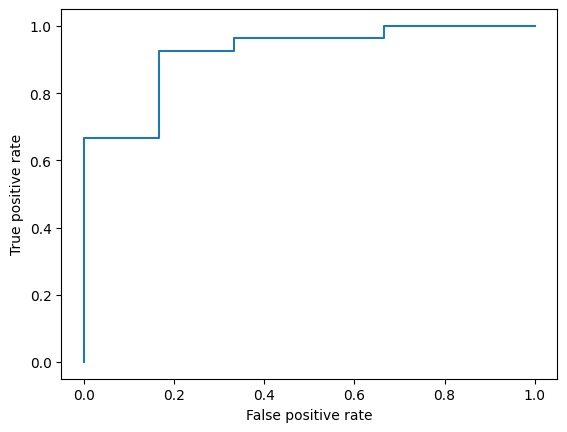

In [6]:
# use ER features
x = features[ER_features1]
# create pipeline with scaler and logistic regression
pipe = Pipeline([('scaler', StandardScaler()), ('logistic', LogisticRegression())])
# create grid search
grid = GridSearchCV(pipe, {'logistic__C': np.logspace(-4, 4, 50)}, cv=5, verbose=1)
# fit grid search
grid.fit(x, info.labels_list(label))
# get best estimator
best = grid.best_estimator_
# get best score
best_score = grid.best_score_
# get best parameters
best_params = grid.best_params_
# print
print(f'Best score: {best_score}')
print(f'Best parameters: {best_params}')
# compute precision
precision = precision_score(info.labels_list(label), best.predict(x))
print(f'Precision: {precision}')
# F1 score
f1 = f1_score(info.labels_list(label), best.predict(x))
print(f'F1 score: {f1}')
# AUC
auc = roc_auc_score(info.labels_list(label), best.predict_proba(x)[:, 1])
print(f'AUC: {auc}')
# ROC curve
fpr, tpr, threshold = roc_curve(info.labels_list(label), best.predict_proba(x)[:, 1])
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

,probability,prediction .5,label,match
0,0.830923,1,1,True
1,0.357292,0,1,False
2,0.952759,1,1,True
3,0.859080,1,0,False
4,0.998718,1,1,True
5,0.966274,1,1,True
6,0.848975,1,1,True
7,0.923581,1,1,True
8,0.868727,1,1,True
9,0.998260,1,1,True


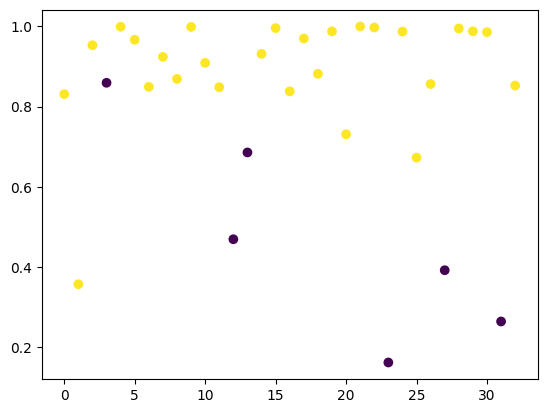

In [54]:
# plot prediciton values
plt.scatter(range(len(info.labels_list(label))), best.predict_proba(x)[:, 1], c=info.labels_list(label))
# print prediction (probability) and label next to each other
pd.DataFrame({'probability': best.predict_proba(x)[:,1], 'prediction .5': best.predict(x), 'label': info.labels_list(label), 'match': best.predict(x) == info.labels_list(label)})

### Leave-one-out (Traditional)

In [26]:
def best_threshold(fpr, tpr, thresholds):
    """given the roc curve information, it returns the best threshold accoridng to the gmean

    Args:
        fpr (np.array): false positiva rate values
        tpr (np.array): true positive rate values
        thresholds (np.array): thresholds found for the ROC curve

    Returns:
        float: optimal threshold
    """
    # Calculate the G-mean
    gmean = np.sqrt(tpr * (1 - fpr))
    # Find the optimal threshold
    index = np.argmax(gmean)
    thresholdOpt = round(thresholds[index], ndigits = 4)
    # gmeanOpt = round(gmean[index], ndigits = 4)
    # fprOpt = round(fpr[index], ndigits = 4)
    # tprOpt = round(tpr[index], ndigits = 4)

    return thresholdOpt

AUC: 0.7901234567901234
Best Threshold: 0.3263 with G-Mean: 0.8012
FPR: 0.3333, TPR: 0.963
//////////////////////////////
Results using threshold: 0.3263
Accuracy: 0.9090909090909091
F1 score: 0.9454545454545454
Precision: 0.9285714285714286
Sensitivity: 0.9629629629629629
Specificity: 0.6666666666666666
MCC: 0.6772962119561564


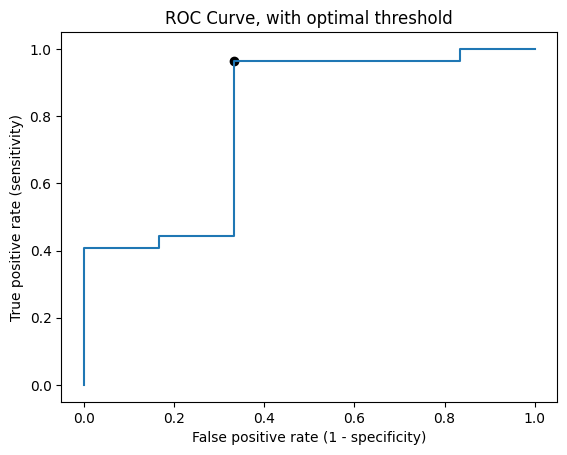

In [9]:
# use specific features
x = features[ER_features1]
# create pipeline with scaler and logistic regression
pipe = Pipeline([('scaler', StandardScaler()), ('logistic', LogisticRegression(penalty='l2', solver='lbfgs',C=3.727593720314938, class_weight='balanced'))])
# leave one out cross validation
loo = LeaveOneOut()
# get prediction probabilities
y_pred_proba = cross_val_predict(pipe, x, info.labels_list(label), cv=loo, method='predict_proba')
# AUC
auc = roc_auc_score(info.labels_list(label), y_pred_proba[:, 1])
print(f'AUC: {auc}')
# ROC curve
fpr, tpr, thresholds = roc_curve(info.labels_list(label), y_pred_proba[:, 1])
plt.plot(fpr, tpr)
plt.xlabel('False positive rate (1 - specificity)')
plt.ylabel('True positive rate (sensitivity)')

# get best threshold using the ROC curve info
# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr))
# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))
# plot the point
plt.scatter(fprOpt, tprOpt, marker='o', color='black', label='Best')
plt.title('ROC Curve, with optimal threshold')

print('//////////////////////////////')
threshold = thresholdOpt
# threshold = 0.5
print(f'Results using threshold: {threshold}')

# compute metrics
# accuracy
accuracy = accuracy_score(info.labels_list(label), y_pred_proba[:, 1] > threshold)
print(f'Accuracy: {accuracy}')
# F1 score
f1 = f1_score(info.labels_list(label), y_pred_proba[:, 1] > threshold)
print(f'F1 score: {f1}')
# precision
precision = precision_score(info.labels_list(label), y_pred_proba[:, 1] > threshold)
print(f'Precision: {precision}')
# sensitivity (recall, TPR)
sensitivity = recall_score(info.labels_list(label), y_pred_proba[:, 1] > threshold)
print(f'Sensitivity: {sensitivity}')
# specificity (TNR)
specificity = recall_score(info.labels_list(label), y_pred_proba[:, 1] > threshold, pos_label=0)
print(f'Specificity: {specificity}')
# MCC
mcc = matthews_corrcoef(info.labels_list(label), y_pred_proba[:, 1] > threshold)
print(f'MCC: {mcc}')


Note: A balanced model can separate the cases with only 2 errors. This is one of the best results so far, even better that in the original paper.

,probability,pred thresh,label,match
0,0.478247,1,1,True
1,0.053106,0,1,False
2,0.869242,1,1,True
3,0.798042,1,0,False
4,0.996811,1,1,True
5,0.780997,1,1,True
6,0.608901,1,1,True
7,0.787132,1,1,True
8,0.568002,1,1,True
9,0.996833,1,1,True


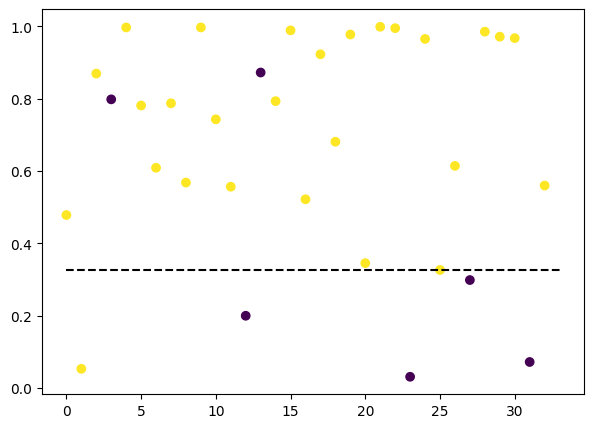

In [10]:
# plot prediciton values, with their corresponding labels in color
plt.figure(figsize=(7,5))
plt.scatter(range(len(info.labels_list(label))), y_pred_proba[:, 1],c=info.labels_list(label))
# plot threshold line
plt.plot([0, len(info.labels_list(label))], [threshold, threshold], 'k--')
# print prediction (probability) and label next to each other
pd.DataFrame({'probability': y_pred_proba[:,1], 'pred thresh': (y_pred_proba[:, 1] > threshold).astype(int), 'label': info.labels_list(label), 'match': (y_pred_proba[:, 1] > threshold) == info.labels_list(label)})

### Evaluation using budget

The unstability of the model is tested using the budget to generate gaussian samples.

In [49]:
# open registration-budget file
regis_budget = pd.read_excel(repo_path / 'data/budget/std.xlsx')
# remove pat number column
regis_budget = regis_budget.drop(columns=['pat_num'])
# mean among all patients
regis_budget = regis_budget.mean(axis=0)
# use only the features that are in the ER features
regis_budget = regis_budget[selected_features]

# open ROI budget file
ROI_budget = pd.read_excel(repo_path / 'data/budget/ROI_std.xlsx')
# change column names
ROI_budget.columns = ['feature', 'budget']
# remove 'original_' text from column feature
ROI_budget['feature'] = ROI_budget['feature'].str.replace('original_', '')
# use only the features that are in the ER features
ROI_budget = ROI_budget[ROI_budget['feature'].isin(selected_features)]
# turn into series
ROI_budget = ROI_budget.set_index('feature')['budget']

# combine both budgets using sqrt of sum of squares
budget = np.sqrt(regis_budget**2 + ROI_budget**2)
budget

shape2D_MinorAxisLength    41.274549
shape2D_Sphericity          0.078496
glcm_Imc2                   0.046696
ngtdm_Contrast              0.024724
dtype: float64

In [50]:
# HP
num_samples = 1000
# use ER features
x = features[selected_features]
# create pipeline with scaler and logistic regression
pipe = Pipeline([('scaler', StandardScaler()), ('logistic', LogisticRegression(penalty='l2', solver='lbfgs',C=3.727593720314938, class_weight='balanced'))])
# create loo using kfold
kfold = KFold(n_splits=x.shape[0])
y = np.array(info.labels_list(label))
# probability matrix
prob_mat = np.zeros(shape=(x.shape[0], num_samples, 2))

for train, test in kfold.split(x, y):
    # fit train data
    pipe.fit(x.iloc[train], y[train])
    # get test data
    x_test = x.iloc[test]
    # generate 1000 random samples from a normal distribution using the x_test values as mean and the budget as std
    samples = np.random.normal(x_test, budget, size=(num_samples, x_test.shape[1]))
    samples = pd.DataFrame(samples)
    samples.columns = x_test.columns # same column names for the standard scaler
    y_proba = pipe.predict_proba(samples)
    prob_mat[test] = y_proba

# the metrics are computed for each gaussian sample
auc = np.zeros(shape=(num_samples,))
accuracy = np.zeros(shape=(num_samples,))
f1 = np.zeros(shape=(num_samples,))
precision = np.zeros(shape=(num_samples,))
sensitivity = np.zeros(shape=(num_samples,))
specificity = np.zeros(shape=(num_samples,))
mcc = np.zeros(shape=(num_samples,))

for i in range(num_samples):
    # compute accuracy
    auc[i] = roc_auc_score(info.labels_list(label), prob_mat[:,i,:][:, 1])
    fpr, tpr, thresholds = roc_curve(info.labels_list(label), prob_mat[:,i,:][:, 1])
    thresholdOpt = best_threshold(fpr, tpr, thresholds)
    threshold = thresholdOpt
    # accuracy
    accuracy[i] = accuracy_score(info.labels_list(label), y_pred_proba[:, 1] > threshold)
    f1[i] = f1_score(info.labels_list(label), y_pred_proba[:, 1] > threshold)
    precision[i] = precision_score(info.labels_list(label), y_pred_proba[:, 1] > threshold)
    sensitivity[i] = recall_score(info.labels_list(label), y_pred_proba[:, 1] > threshold)
    specificity[i] = recall_score(info.labels_list(label), y_pred_proba[:, 1] > threshold, pos_label=0)
    mcc[i] = matthews_corrcoef(info.labels_list(label), y_pred_proba[:, 1] > threshold)


In [51]:
# mean of all metrics
print('////////////Metrics////////////')
# onlt two decimals of mean
print(f'AUC: {auc.mean():.2f} +- {auc.std():.2f}')
print(f'Accuracy: {accuracy.mean():.2f} +- {accuracy.std():.2f}')
print(f'F1 score: {f1.mean():.2f} +- {f1.std():.2f}')
print(f'Precision: {precision.mean():.2f} +- {precision.std():.2f}')
print(f'Sensitivity: {sensitivity.mean():.2f} +- {sensitivity.std():.2f}')
print(f'Specificity: {specificity.mean():.2f} +- {specificity.std():.2f}')
print(f'MCC: {mcc.mean():.2f} +- {mcc.std():.2f}')

////////////Metrics////////////
AUC: 0.77 +- 0.09
Accuracy: 0.70 +- 0.16
F1 score: 0.77 +- 0.16
Precision: 0.91 +- 0.04
Sensitivity: 0.70 +- 0.23
Specificity: 0.66 +- 0.21
MCC: 0.35 +- 0.15


In [47]:
# mean of all metrics
print('////////////Metrics////////////')
# onlt two decimals of mean
print(f'AUC: {auc.mean():.2f} +- {auc.std():.2f}')
print(f'Accuracy: {accuracy.mean():.2f} +- {accuracy.std():.2f}')
print(f'F1 score: {f1.mean():.2f} +- {f1.std():.2f}')
print(f'Precision: {precision.mean():.2f} +- {precision.std():.2f}')
print(f'Sensitivity: {sensitivity.mean():.2f} +- {sensitivity.std():.2f}')
print(f'Specificity: {specificity.mean():.2f} +- {specificity.std():.2f}')
print(f'MCC: {mcc.mean():.2f} +- {mcc.std():.2f}')

////////////Metrics////////////
AUC: 0.74 +- 0.09
Accuracy: 0.72 +- 0.14
F1 score: 0.79 +- 0.13
Precision: 0.91 +- 0.04
Sensitivity: 0.73 +- 0.20
Specificity: 0.65 +- 0.18
MCC: 0.37 +- 0.15


### Training and evaluationg using budget

In [41]:
# open registration-budget file
regis_budget = pd.read_excel(repo_path / 'data/budget/std.xlsx')
# remove pat number column
regis_budget = regis_budget.drop(columns=['pat_num'])
# mean among all patients
regis_budget = regis_budget.mean(axis=0)
# use only the features that are in the ER features
regis_budget = regis_budget[selected_features]

# open ROI budget file
ROI_budget = pd.read_excel(repo_path / 'data/budget/ROI_std.xlsx')
# change column names
ROI_budget.columns = ['feature', 'budget']
# remove 'original_' text from column feature
ROI_budget['feature'] = ROI_budget['feature'].str.replace('original_', '')
# use only the features that are in the ER features
ROI_budget = ROI_budget[ROI_budget['feature'].isin(selected_features)]
# turn into series
ROI_budget = ROI_budget.set_index('feature')['budget']

# combine both budgets using sqrt of sum of squares
budget = np.sqrt(regis_budget**2 + ROI_budget**2)

In [96]:
# HP
num_val_samples = 1000
num_train_samples = 50
# use ER features
x = features[selected_features]
# create pipeline with scaler and logistic regression
pipe = Pipeline([('scaler', StandardScaler()), ('logistic', LogisticRegression(penalty='l2', solver='lbfgs',C=3.727593720314938, class_weight='balanced'))])
# create loo using kfold
kfold = KFold(n_splits=x.shape[0])
y = np.array(info.labels_list(label))
# probability matrix
prob_mat = np.zeros(shape=(x.shape[0], num_val_samples, 2))

for train, test in kfold.split(x, y):
    # fit train data
    x_train = x.iloc[train]
    y_train = y[train]
    # generate random samples and add them to the train data
    x_train_extended = None
    for i, train_sample in x_train.iterrows():
        # create 50 random samples for each train sample
        samples = np.random.normal(train_sample, budget, size=(num_train_samples, x_train.shape[1]))
        # concat samples
        x_train_extended = pd.concat([x_train_extended, pd.DataFrame(samples)])
    # add original
    x_train_extended.columns = x_train.columns
    x_train_extended = pd.concat([x_train_extended, x_train])
    x_train_extended = x_train_extended.reset_index(drop=True)
    # replicate y_train
    y_train_replicated = np.repeat(y_train, num_train_samples+1)

    pipe.fit(x_train_extended, y_train_replicated)
    # get test data
    x_test = x.iloc[test]
    # generate 1000 random samples from a normal distribution using the x_test values as mean and the budget as std
    samples = np.random.normal(x_test, budget, size=(num_val_samples, x_test.shape[1]))
    samples = pd.DataFrame(samples)
    samples.columns = x_test.columns # same column names for the standard scaler
    y_proba = pipe.predict_proba(samples)
    prob_mat[test] = y_proba

# the metrics are computed for each gaussian sample
auc = np.zeros(shape=(num_val_samples,))
accuracy = np.zeros(shape=(num_val_samples,))
f1 = np.zeros(shape=(num_val_samples,))
precision = np.zeros(shape=(num_val_samples,))
sensitivity = np.zeros(shape=(num_val_samples,))
specificity = np.zeros(shape=(num_val_samples,))
mcc = np.zeros(shape=(num_val_samples,))

for i in range(num_val_samples):
    # compute accuracy
    auc[i] = roc_auc_score(info.labels_list(label), prob_mat[:,i,:][:, 1])
    fpr, tpr, thresholds = roc_curve(info.labels_list(label), prob_mat[:,i,:][:, 1])
    thresholdOpt = best_threshold(fpr, tpr, thresholds)
    threshold = thresholdOpt
    # accuracy
    accuracy[i] = accuracy_score(info.labels_list(label), y_pred_proba[:, 1] > threshold)
    f1[i] = f1_score(info.labels_list(label), y_pred_proba[:, 1] > threshold)
    precision[i] = precision_score(info.labels_list(label), y_pred_proba[:, 1] > threshold)
    sensitivity[i] = recall_score(info.labels_list(label), y_pred_proba[:, 1] > threshold)
    specificity[i] = recall_score(info.labels_list(label), y_pred_proba[:, 1] > threshold, pos_label=0)
    mcc[i] = matthews_corrcoef(info.labels_list(label), y_pred_proba[:, 1] > threshold)


In [97]:
# mean of all metrics
print('////////////Metrics////////////')
# onlt two decimals of mean
print(f'AUC: {auc.mean():.2f} +- {auc.std():.2f}')
print(f'Accuracy: {accuracy.mean():.2f} +- {accuracy.std():.2f}')
print(f'F1 score: {f1.mean():.2f} +- {f1.std():.2f}')
print(f'Precision: {precision.mean():.2f} +- {precision.std():.2f}')
print(f'Sensitivity: {sensitivity.mean():.2f} +- {sensitivity.std():.2f}')
print(f'Specificity: {specificity.mean():.2f} +- {specificity.std():.2f}')
print(f'MCC: {mcc.mean():.2f} +- {mcc.std():.2f}')

////////////Metrics////////////
AUC: 0.72 +- 0.08
Accuracy: 0.80 +- 0.08
F1 score: 0.87 +- 0.06
Precision: 0.91 +- 0.01
Sensitivity: 0.83 +- 0.10
Specificity: 0.65 +- 0.05
MCC: 0.45 +- 0.12


## Train

### Logistic regression

In [ ]:
x = features[coef.index] # use only the lasso selected features
# scale features using standard scaler
scaler = StandardScaler()
x = scaler.fit_transform(x)
y = info.labels_list(label)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(x, y)
# get the accuracy of the model
print(f'Accuracy: {logreg.score(x, y)}')
print(f'A dumb prediction would have an accuracy of: {np.mean(y)}')

Accuracy: 0.9090909090909091
A dumb prediction would have an accuracy of: 0.8181818181818182


In [ ]:
# run a lasso classifier with all the features using leave one out cross validation
# LOOCV
loo = LeaveOneOut()
loo.get_n_splits(features)
scores = []
y = np.array(y)
for train_index, test_index in loo.split(features):
    X_train, X_test = features.iloc[train_index][coef.index], features.iloc[test_index][coef.index]
    y_train, y_test = y[train_index], y[test_index]
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # clf = RandomForestClassifier(n_estimators=100)
    clf = LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga', l1_ratio=0.5)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))
print(scores)
print(f'Accuracy: {np.mean(scores)}')

[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0]
Accuracy: 0.8181818181818182


### Random forest

In [ ]:
# run a lasso classifier with all the features using leave one out cross validation
# LOOCV
loo = LeaveOneOut()
loo.get_n_splits(features)
scores = []
y = np.array(y)
for train_index, test_index in loo.split(features):
    X_train, X_test = features.iloc[train_index][coef.index], features.iloc[test_index][coef.index]
    y_train, y_test = y[train_index], y[test_index]
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))
print(f'Accuracy: {np.mean(scores)}')

Accuracy: 0.6060606060606061
